# Project 3 Web APIs & Classification

## Data Cleaning

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup  
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer


%matplotlib inline
sns.set(font_scale=1.5)

#### 1. Data Cleaning

In [2]:
#load the CSV file in case not scraping
df = pd.read_csv('../data/game.csv')

In [3]:
#display first 10 row of the dataframe
df.head(10)

,title,selftext,subreddit,num_comments,upvote
0,Welcoming Bethesda to the Xbox Family,&amp;#x200B;\n\nhttps://preview.redd.it/du20aq...,XboxSeriesX,76,0.94
1,"Beginner's Guide to XSX/XSS, Game Pass, Storag...",Welcome to the Xbox family!\n\nThe next genera...,XboxSeriesX,20,0.95
2,Sharing this coloured pencil fanart of Master ...,NaN,XboxSeriesX,56,0.98
3,Tom Warren on Twitter - Microsoft will make Be...,NaN,XboxSeriesX,208,0.96
4,"Someone sent me this, I thought you might like it",NaN,XboxSeriesX,299,0.93
5,Why does there seem to be this aura of “Micros...,I don’t get it. All the people complaining abo...,XboxSeriesX,221,0.88
6,Today I started messing around with etching de...,NaN,XboxSeriesX,9,0.92
7,I won a Series X from Taco Bell!,.....from a $5 box. Stared at my phone for sev...,XboxSeriesX,26,0.80
8,MKBHD teasing his working Series X,NaN,XboxSeriesX,36,0.81
9,Does anyone else just check the status of your...,NaN,XboxSeriesX,132,0.90


In [4]:
# Check for Nan value
df.isnull().sum()

title             0
selftext        696
subreddit         0
num_comments      0
upvote            0
dtype: int64

#### Address Missing Values
There are the missing value in the "selftext" column. It seems some people will post a title without further explanation during their posting. And some people will give an additional explanation for their post titles in the post content section. Although not all posts have texts, their titles are complete. So I think it is better to combine the string columns"title" and "selftext" for modeling instead of dropping all missing values.

In [5]:
# fill NAN with empty string for the combination
df.selftext.fillna(value='', inplace=True)

In [6]:
#combine the two string columns "title" and "selftext" and add a space between the text
df["feature"] = df["title"] + " " + df["selftext"]

In [7]:
#check the text after combination
df["feature"][0]

"Welcoming Bethesda to the Xbox Family &amp;#x200B;\n\nhttps://preview.redd.it/du20aqzqedp51.jpg?width=1920&amp;format=pjpg&amp;auto=webp&amp;s=db5193c62a37d86f6a72dbe5bf1db4f064bb32f1\n\nHey everybody,\n\nIn celebration of Bethesda joining the Xbox family, we’d like to take this opportunity to acknowledge the awesome communities that’ll be joining the Xbox family, too:\n\n* [r/BethesdaSoftworks](https://www.reddit.com/r/BethesdaSoftworks/): A fan-made community dedicated to all games, mods, and projects related to the game publisher Bethesda Softworks and its subsidiary developer studios.\n* [r/dishonored](https://www.reddit.com/r/dishonored/): Subreddit for the Arkane Studios video games Dishonored, Dishonored 2, and Dishonored: Death of the Outsider™.\n* [r/Doom](https://www.reddit.com/r/Doom/): Everything related to the hit action-horror series DOOM, by id software.\n* [r/ElderScrolls](https://www.reddit.com/r/ElderScrolls/): A community dedicated the Elder Scrolls franchise, devel

In [8]:
#Check for Nan value again
df.isnull().sum()

title           0
selftext        0
subreddit       0
num_comments    0
upvote          0
feature         0
dtype: int64

In [9]:
#check the datatype for the dataframe
df.dtypes

title            object
selftext         object
subreddit        object
num_comments      int64
upvote          float64
feature          object
dtype: object

#### Remove duplicate rows

In [10]:
#check duplicate rows in dataframe
df.duplicated().value_counts()

False    2164
True      312
dtype: int64

In [11]:
#drop teh duplicate rows in dataframe
df=df.drop_duplicates()

In [12]:
#check the dataframe shape again
df.shape

(2164, 6)

#### Statistic Summary
To make sure our post collected are all relevant posts, I also look at the statistic summary for each post's number of comments and upvote ratio(upvotes/total votes).If there is a post with 0 comments or extremely low upvote ratio, I assume that it has a high chance of an unrelated post. From the below table and graph, we can see that a mean and median number of comments of 109 and 26  respectively, 50% post with comment number between 11 to 62. The max number of comments is 22002; a mean and median number of upvote ratio of 0.65 and 0.68  respectively, 50% post with upvote ratio between 0.46 to 0.85. The max upvote ration is 1.0. There are the outliers with min number of comments of 0, and min upvote ratio 0.04 which we are interested in.  I will exam whether they are the relevant posts.

In [13]:
#display the statistic summary
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num_comments,2164.0,109.677449,788.356527,0.00,11.00,26.00,62.00,22002.0
upvote,2164.0,0.646543,0.234415,0.04,0.46,0.68,0.85,1.0


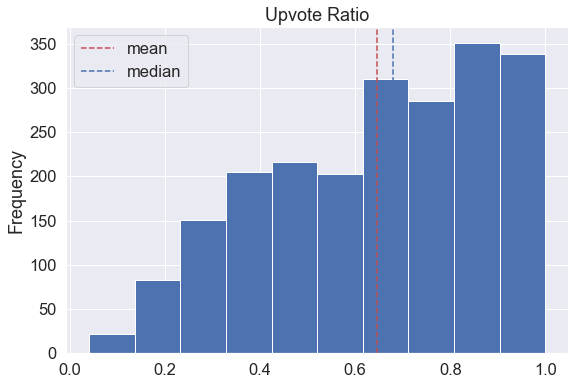

In [14]:
#plotting distribution of upvote
plt.figure(figsize=(9,6))
plt.hist(df['upvote'])
plt.title('Upvote Ratio')
plt.ylabel('Frequency')

#draw line showing mean
plt.axvline(df['upvote'].mean(), linestyle = '--', color = 'r', label ='mean')
#draw line showing median
plt.axvline(df['upvote'].median(), linestyle = '--', color = 'b', label ='median')
plt.legend()

#### Address the outliers

The post with 0 comments is about the story trailer for Scarlet Nexus, a game developed for PS5 and XboxSeries. The content is relevant to our modeling. The post with an upvote ratio 0.04 is about the PS5 game Spiderman, which is also related to our modeling.  All the interested outliers are the reasonable value, they have 0 comments, and the low upvote ratio may due to the post being very new. I am not going to remove it from the dataframe. And the hottest post with the highest number of comments regards the PS5 pre-orders.

In [15]:
#check the outlier
df[df["num_comments"]==0]

,title,selftext,subreddit,num_comments,upvote,feature
77,Scarlet Nexus ‘Story Trailer: Yuito,,XboxSeriesX,0,0.67,Scarlet Nexus ‘Story Trailer: Yuito


In [16]:
#check the outlier
df[df["num_comments"]==22002]

,title,selftext,subreddit,num_comments,upvote,feature
2473,PlayStation 5 Pre-order Megathread Redux,With more pre-order allocation stock being rel...,PS5,22002,0.97,PlayStation 5 Pre-order Megathread Redux With ...


In [17]:
#check the outlier
df[df["upvote"]==0.04]["title"].values

array(['Do you guys think the new spider man will come with new game plus'],
      dtype=object)

#### Save the clean data

In [18]:
#save the cleaned data to csv file
df.to_csv('../data/game_clean.csv', index=False)

#### Data Dictionary

|Features                    | Type    |Description
|:---------------------------|:--------|:----------------------------------------------------------------------------------------
| title                      | object  |Post title
| selftext                   | object  |Post content under the title
| subreddit                  | object  |Target variable
| feature                    | object  |combined text for Post title and post content